In [1]:
import evaluate
import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error as mse
import glob
import os
import cv2
import pandas as pd
import numpy as np
import imp
import time
import random
import dlib
from imgaug import augmenters as iaa
from metrics import *
imp.reload(evaluate)
%matplotlib inline

## Load ground truth annotations

In [2]:
data_folder = './tiny/data/widerface/WIDER_val/images/'
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'

In [3]:
with open('./tiny/data/widerface/wider_face_val_bbx_gt.txt') as f:
    annotation_file = [k.strip() for k in f.readlines()]
    
image_name = [k for k in annotation_file if '--' in k]
d = {} 
# d[name] = [(x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose)]
for name in image_name:
    n_index = annotation_file.index(name)
    n_pictures = int(annotation_file[n_index+1])
    d[name] = annotation_file[n_index+2:n_index+2+n_pictures]

In [44]:
# Most annotated faces 
# sorted([(k,len(v)) for k,v in d.items()],key=lambda x:x[1], reverse=True)

# [(k,len(v)) for k,v in d.items() if '2--Demonstration/' in k and len(v) == 8]

## Predictions on one class

In [5]:
data_dir = glob.glob(data_folder+'*')[1] + '/' # Parade folder

In [6]:
tic = time.time()
with tf.Graph().as_default():
    b = evaluate.evaluate(weight_file_path=weights_path, data_dir=data_dir)
toc = time.time()
print('It took %d sec' % (toc-tic))

It took 177 sec


In [7]:
a, df = metrics.compute_stats(data_dir, d, b)
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df.Nb_Pred_Bboxes.sum(),
       df.Nb_Truth_Bboxes.sum(), df.Nb_Pred_Bboxes.sum() / df.Nb_Truth_Bboxes.sum(),
       df.mJaccard.mean()))

5641/9108 (0.62) bounding boxes found over all images of the folder
Mean Jaccard : 0.75


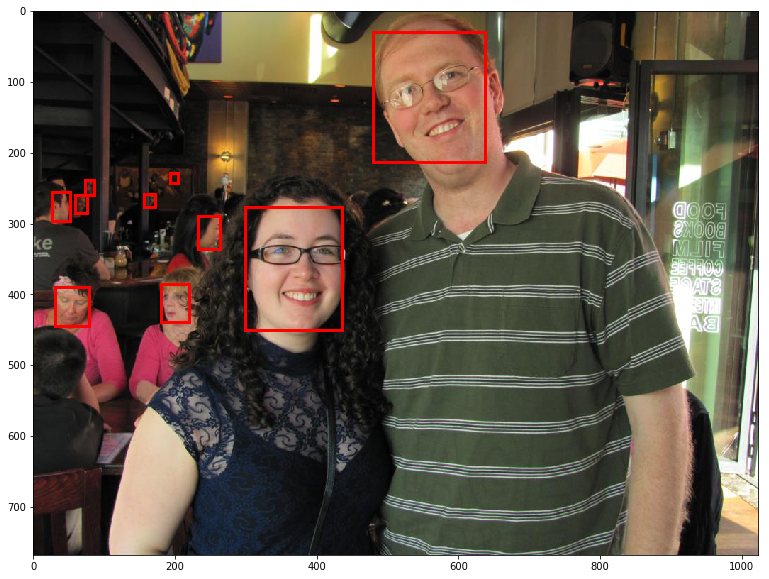

In [43]:
f, ax = plt.subplots(figsize=(13,13))
#idx = [k.replace(data_folder, '') for k in glob.glob(data_dir + '*')].index('2--Demonstration/2_Demonstration_Political_Rally_2_891.jpg')
idx = 240
pic = glob.glob(data_dir + '*')[idx]
img_truth = cv2.imread(pic)[:,:,::-1]
ax.imshow(img_truth)
color = 'r'#(0/255,202/255,155/255, 1)

# plot the predicted bounding boxes
for k in b[idx]:
    x1, y1 = k[:2]
    w, h = k[2] - k[0], k[3] - k[1]
    rect = patches.Rectangle((x1,y1),w, h,linewidth=3,edgecolor=color,facecolor='none')
    ax.add_patch(rect)


In [165]:
a, df_blurred = metrics.compute_stats(data_dir, d, b, blurred=2)
print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
Mean Jaccard : %.2f' % (df_blurred.Nb_Pred_Bboxes.sum(),
       df_blurred.Nb_Truth_Bboxes.sum(), df_blurred.Nb_Pred_Bboxes.sum() / df_blurred.Nb_Truth_Bboxes.sum(),
       df_blurred.mJaccard.mean()))

2865/5879 (0.49) bounding boxes found over all images of the folder
Mean Jaccard : 0.71


/home/alexattia/Work/RecVis/metrics.py:128: RuntimeWarning: invalid value encountered in true_divide
  a[:,3] = a[:,2]/a[:,1]


### Effect of blurred regions on detections for a specific image

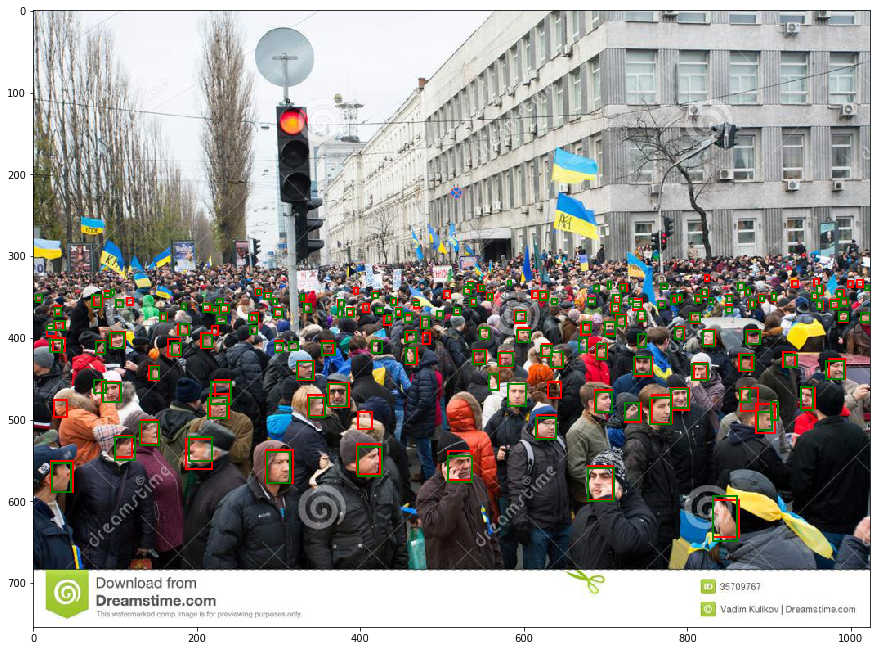

In [166]:
f, ax = plt.subplots(figsize=(15,15))
idx = 25
pic = glob.glob(data_dir + '*')[idx]
img_truth = cv2.imread(pic)[:,:,::-1]
ax.imshow(img_truth)

# plot the predicted bounding boxes
for k in b[idx]:
    x1, y1 = k[:2]
    w, h = k[2] - k[0], k[3] - k[1]
    rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

# plot the ground truth bounding boxes
for k in d[pic.replace(data_folder, '')]:
    _, jd = find_best_bbox(k, b[idx])
    (x1, y1, w, h, _, _, _, _, _, _) = map(int, k.split())
    rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    #if jd > 0:
        #ax.text(x1-5, y1-5, '%.2f' % jd, color='r')

## Predictions on multi-class

In [167]:
data_dir = glob.glob(data_folder+'*')

In [170]:
np.array(glob.glob(data_folder+'*'))[np.array([1, 4, 57])]

array(['./tiny/data/widerface/WIDER_val/images/2--Demonstration',
       './tiny/data/widerface/WIDER_val/images/12--Group',
       './tiny/data/widerface/WIDER_val/images/35--Basketball'],
      dtype='<U66')

In [52]:
ind_class = [1, 4, 57]
pred = {}
for i in ind_class:
    tic = time.time()
    with tf.Graph().as_default():
        dire = data_dir[i] + '/'
        pred[i] = evaluate.evaluate(weight_file_path=weights_path, data_dir=dire)
    toc = time.time()
    print('Class %d took %d sec' %(i , (toc-tic)))

Class 1 took 170 sec
Class 4 took 101 sec
Class 57 took 97 sec


In [53]:
a_full = {}
df_full = {}
for i in ind_class:
    a_full[i], df_full[i] = metrics.compute_stats(data_dir[i] + '/', d, pred[i])
    print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
    Mean Jaccard : %.2f' % (df_full[i].Nb_Pred_Bboxes.sum(),
       df_full[i].Nb_Truth_Bboxes.sum(), df_full[i].Nb_Pred_Bboxes.sum() / df_full[i].Nb_Truth_Bboxes.sum(),
       df_full[i].mJaccard.mean()))

5641/9108 (0.62) bounding boxes found over all images of the folder
    Mean Jaccard : 0.75
2307/2542 (0.91) bounding boxes found over all images of the folder
    Mean Jaccard : 0.79
1766/3644 (0.48) bounding boxes found over all images of the folder
    Mean Jaccard : 0.75


In [54]:
a_blurred = {}
df_blurred = {}
for i in ind_class:
    a_blurred[i], df_blurred[i] = metrics.compute_stats(data_dir[i] + '/', d, pred[i], blurred=2)
    print('%d/%d (%.2f) bounding boxes found over all images of the folder\n\
    Mean Jaccard : %.2f' % (df_blurred[i].Nb_Pred_Bboxes.sum(),
       df_blurred[i].Nb_Truth_Bboxes.sum(), df_blurred[i].Nb_Pred_Bboxes.sum() / df_blurred[i].Nb_Truth_Bboxes.sum(),
       df_blurred[i].mJaccard.mean()))

/home/alexattia/Work/RecVis/metrics.py:128: RuntimeWarning: invalid value encountered in true_divide
  a[:,3] = a[:,2]/a[:,1]


2865/5879 (0.49) bounding boxes found over all images of the folder
    Mean Jaccard : 0.71
1112/1296 (0.86) bounding boxes found over all images of the folder
    Mean Jaccard : 0.74
1245/3049 (0.41) bounding boxes found over all images of the folder
    Mean Jaccard : 0.74


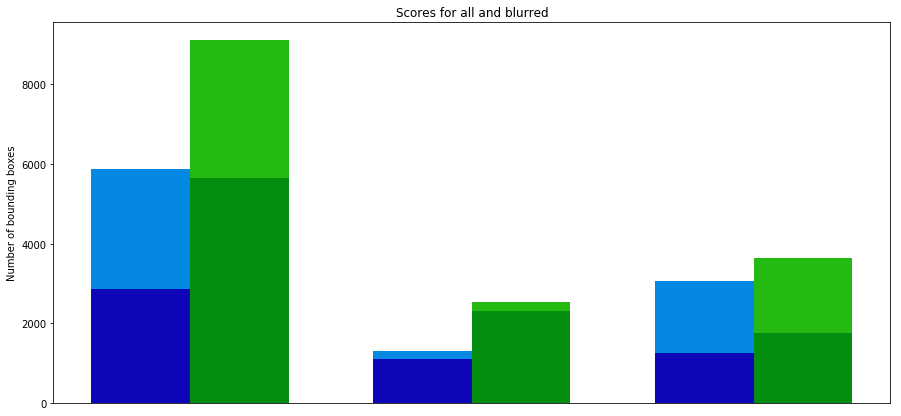

In [157]:
space = 0.3
n = len(conditions_tot)
width = (1 - space) / (len(conditions_tot))
color_b = [(13/255, 6/255, 185/255, 1), (3/255, 142/255, 15/255, 1)]
color_t = [(4/255, 136/255, 225/255, 1), (37/255, 186/255, 17/255, 1)]
plt.figure(figsize=(15,7))

l_tot = []
l_pred = []
for i in ind_class:
    l_tot.append(['Total Truth','Classe' + str(i),df_full[i].Nb_Truth_Bboxes.sum()])
    l_tot.append(['Blurred Truth','Classe' + str(i),df_blurred[i].Nb_Truth_Bboxes.sum()])
    l_pred.append(['Total Pred','Classe' + str(i),df_full[i].Nb_Pred_Bboxes.sum()])
    l_pred.append(['Blurred Pred','Classe' + str(i),df_blurred[i].Nb_Pred_Bboxes.sum()])
l_tot = np.array(l_tot)    
l_pred = np.array(l_pred)
    
conditions_tot = np.unique(l_tot[:,0])
categories_tot = np.unique(l_tot[:,1])    
conditions_pred = np.unique(l_pred[:,0])
categories_pred = np.unique(l_pred[:,1])   

for i,cond in enumerate(conditions_tot):
    vals = l_tot[l_tot[:,0] == cond][:,2].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width for j in range(1,len(categories_tot)+1)]
    plt.bar(pos, vals, width=width,label=cond, color=color_t[i])
    
for i,cond in enumerate(conditions_pred):
    vals = l_pred[l_pred[:,0] == cond][:,2].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width for j in range(1,len(categories_pred)+1)]
    plt.bar(pos, vals, width=width, label=cond, color=color_b[i])
    
plt.ylabel('Number of bounding boxes')
plt.title('Scores for all and blurred')
plt.xticks([], [])
plt.show()